### Quick overview of the QSVM

This is a quick implementation of the work done in [this paper](https://arxiv.org/abs/1804.11326). The article presents two ways to implement a SVM (Support Vector Machine) or SVM-like algorithm using (supposedly) classicaly hard to compute feature map. The authors did two different implementations: one using a variational approach (they optimize the parameters of a part of the circuit), and the other directly computing the kernel Gram matrix and test matrix.

Here we will see both implementations, without any pretention to do anything perfectly optimized but still usable. For all tests we will use two-dimensional data (points on a plane), and so the code could be hard to generalize. But technically any data can be mapped the way the authors presented in the paper.


#### Data generation

Firstly, we want to be able to generate data that will serve as a test. The data would have to be separated by a hyperplan in the quantum state space (of density matrix, not directly the Hilbertian of state vectors), for us to be able to compare the hyperplan we found using variational or normal SVM to the real one. Furthermore, we can use this data to compare the method to SVM using classical kernels, to give an idea of the quantum advantage here.

Firstly, we will create the functions that adds the different components to a given circuit, and use them to generate the data using a random hyperplan. The way this works is that we want to map normal data (points on a plane) to a quantum state, and then label the data using an hyperplane spliting the density matrix space in two. To do that, the authors used a quantum circuit divided in two main parts:

The first part is the mapping circuit, encoding the data. It's composed of two steps, repeated two times. First, Hadamard on all qubits, then a diagonal gate depending on the data.
<img src="images/uphi.PNG" width="400"/>

It puts the qubits in the state $\mathcal{U}_\Phi(x)|0_n>=U_{\Phi(x)}H_nU_{\Phi(x)}H_n|0_n>$. The goal of this part is to encode the data a way classical algotithm will have trouble simulating. To do that, the authors proposed this version of the gate $=U_{\Phi(x)}$:

![uphi_details.PNG](images/uphi_details.PNG)

Where the $\phi$ gate are just rotations following this rule: $\phi_i(x)=x_i$ and $\phi_{i,j}(x) = (\pi-x_i)(\pi-x_j)$



Then, now that the state is correctly mapped to a space hard to simulate, we will put it through a random 2-qubits gate $\in SU(4)$. For this all we have to do is randomly pick 6 values, and put two 1-qubits $u_3$ (taking three parameters each). This will efficiently divide the state vector, and then we just have to map each value to $-1$ or $+1$ according to a function $f:\{0,1\}\rightarrow \{-1,1\}$ (here we just chose a XOR, so both $00$ and $11$ map to $-1$). The final state (in density matrix notation), is now $<0_n|\mathcal{U}_\Phi(x)V^{*}fV\mathcal{U}_\Phi(x)|0_n>$. Sampling from this will give a value in $[-1,1]$ for a given $x$, and, given a threshold $\Delta$, depending if it's above it or below $-\Delta$, we label it either $1$ or $-1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ
import random as r
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import SPSA
from sklearn import svm, datasets

In [2]:
IBMQ.load_accounts()

In [3]:
def Uphi(circ, q, x, RegX):
    """Adds a Uphi(x) gate to circ at RegX. x and RegX must be of size 2 here"""
    for reg in RegX:
        circ.h(reg)
    Phi = [x[0], x[1], (np.pi-x[0])*(np.pi-x[1])]
    circ.u1(-2 * Phi[0], RegX[0])
    circ.u1(-2 * Phi[1], RegX[1])
    circ.cx(RegX[0], RegX[1])
    circ.u1(-2 * Phi[2], RegX[1])
    circ.cx(RegX[0], RegX[1])
    for reg in RegX:
        circ.h(reg)
    circ.u1(-2 * Phi[0], RegX[0])
    circ.u1(-2 * Phi[1], RegX[1])
    circ.cx(RegX[0], RegX[1])
    circ.u1(-2 * Phi[2], RegX[1])
    circ.cx(RegX[0], RegX[1])
    circ.barrier(q)
    return 1

def measure_direct(circ, reg, targ):
    """Returns circ with measures added on reg on each qbit index specified in targ"""
    c = ClassicalRegister(len(targ), 'c')
    meas = QuantumCircuit(reg, c)
    for i in range(len(targ)):
        meas.measure(targ[i], c[i])
    return circ + meas

def launch(n, circ):
    """Create a backend and launch circ n times on it"""
    backend_sim = BasicAer.get_backend('qasm_simulator')
    job_sim = execute(circ, backend_sim, shots=n)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ)
    return counts

def generation(n, delta):
    """We want to generate data hard to learn for a classical machine learning algo.
    We generate couples and then apply a map on it. Returns a list labeled -1,
    an other labeled +1, and the two parameters sets used to generate the labels"""
    # The list of -1 labeled data
    N = []
    # The list of 1 labeled data
    P = []
    # The two random SU(2) gates to form the SU(4) gate
    V1 = [r.random() * np.pi, r.random() * 2 * np.pi, r.random() * 2 * np.pi]
    V2 = [r.random() * np.pi, r.random() * 2 * np.pi, r.random() * 2 * np.pi]
    # Just a number to see the advancement
    bt = 0
    print("Start of the generation, 0 postive label and 0 negative label...")
    while len(N) < n or len(P) < n:

        bt += 1
        if not bt%50:
            print("Try number", bt, "Positive label: {}, Negative label: {}...".format(len(P), len(N)))

        # We take a random point
        x = (r.random() * 2 * np.pi, r.random() * 2 * np.pi)

        #We create the circuit to map it and label it
        q = QuantumRegister(2, 'q')
        circ = QuantumCircuit(q)
        Uphi(circ, q, x, [q[0], q[1]])
        circ.u3(V1[0], V1[1], V1[2], q[0])
        circ.u3(V2[0], V2[1], V2[2], q[1])
        circ_m = measure_direct(circ, q, [q[0], q[1]])
        counts = launch(2048, circ_m)

        # Now, we will decide it's label
        res = 0
        for key in counts:
            if key[0] == key[1]:
                res += counts[key]
            else:
                res -= counts[key]
        # This is the mean result, the one we will use to decide the label
        res = res/2048
        # delta is the threshold, for the two labeled zones to be clearly separated.
        if res > delta and len(P) < n:
            P.append(x)
        if res < -delta and len(N) < n:
            N.append(x)
    print("Done! {} postive labeled data and {} negative labeled data!".format(len(P), len(N)))
    # We can see the final map
    plt.scatter([p[0] for p in P], [p[1] for p in P])
    plt.scatter([p[0] for p in N], [p[1] for p in N])
    plt.show()
    # We also return the parameters used for V1 and V2 if we want to compare different data using the same map.
    return N, P, V1, V2

Start of the generation, 0 postive label and 0 negative label...
Try number 50 Positive label: 15, Negative label: 13...
Done! 20 postive labeled data and 20 negative labeled data!


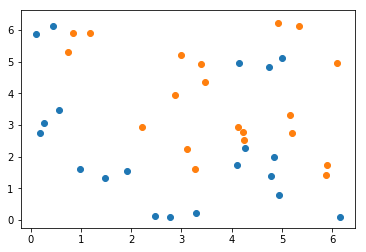

In [4]:
# It will create 20 labeled data for each label, so 40 data in total
gener = generation(20, 0.3) 

Now, we have to use this data. There is two algorithms presented in the article to try to find the good hyperplane. Of course, this seems a little bit artificial, because we already know that the data was mapped on a quantum state using the exact map we use to learn, so it will find the true hyperplane we used to generate the data. But other data may benefit from this high dimensional mapping as well, and this generated data is really hard to correctly separate for a normal SVM using classical kernels.

#### Variational classification

The fisrt algorhtm presented in the paper is quite logical when we know how was build the data. The circuit used is again in two parts, the first is the same (the mapping circuit), and the other is almost the same, but instead of a random unitary matrix, we have a parametred circuit which will eventually behave like the random gate used for the generation. 

This second circuit has parameters that will be optimized using the result of the circuit as an error. To compute the error, it's simple: you run the algorithm $R$ times, you use a function $f$ just like the generation (it can be a different one but I used the same) to map the output to $\{61,1\}$, and so you have the number of time you got $-1$ or 1, so you have an estimation of the probability of getting each label. Then using [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy) or the error function presented in the paper (both works, but cross entropy is more classical), you can have a general error associated to the parameters, to be minimized using an optimizer (here SPSA).

This second part of the circuit is composed of $l$ layers, like that:

![w.PNG](images/w.PNG)

Each entanglign gate here is a $CZ$ but it can be something else, so we have $2n(l+1)$ parameters to optimize (two by gate). So the circuit is usally short enough to be run on real device, but I won't do that because each call will have to wait on the queue. Here is the implementation.

In [5]:
def W(circ, q, RegX, Theta):
    """Place a Variational Trainable circuit on circ at RegX"""
    for i in range(len(RegX)):
        circ.u3(Theta[i + len(RegX)], 0.0, 0.0, RegX[i])
        circ.u1(Theta[i], RegX[i])
    for i in range(2*len(RegX), len(Theta), 2*len(RegX)):
        circ.barrier(q)
        circ.u2(0.0, np.pi, RegX[-1])
        circ.cx(RegX[0], RegX[-1])
        circ.u2(0.0, np.pi, RegX[-1])
        for j in range(len(RegX)):
            circ.u3(Theta[i + j + len(RegX)], 0.0, 0.0, RegX[j])
            circ.u1(Theta[i+j], RegX[j])
    circ.barrier(q)
    return 1

def sig(x):
    """Sigmoid"""
    return 1/(1+np.exp(-x))

def pmdm(R, py, y, b):
    """returns p(m(x)!=mhat(x))"""
    return sig( (np.sqrt(R)*( 0.5*(1-y*b) - py ))/np.sqrt(2*(1-py)*py) )


def clamp(x, a, b):
    """np.clip in fact"""
    return a * (x < a) + x * (x >= a and x <= b) + b * (x > b)

def Variationer_learn(data, shots, l, epsilon, test=None):
    """Learn the theta to find the data. data is of the form list (list (tuple label)).
    Shots is the amount of shots to take for the empirical evaluation of p_y.
    l is the depth of the variationner"""
    # Number of qubits used
    n = len(data[0])
    # Initial random theta
    Theta = np.random.normal(0, 1, 2*n*(l+1))
    # Initial circuit
    q = QuantumRegister(2, 'q')
    RegX = [q[i] for i in range(n)]
    # To keep track of what's done
    curve = []

    def Remp(theta):
        """The error function"""
        # Part of the circuit common to all data
        circ = QuantumCircuit(q)
        W(circ, q, RegX, theta)
        # For each data, compute the error
        err_theta = 0
        for i in range(len(data)):
            # We create the circuit for this data
            circ_uphi = QuantumCircuit(q)
            Uphi(circ_uphi, q, data[i][0], RegX)
            circ_var = circ_uphi + circ
            circ_m = measure_direct(circ_var, q, RegX)
            counts = launch(shots, circ_m)
            # We count each label
            res = 0
            for KEY in counts:
                if KEY[0] == KEY[1]:
                    res += counts[KEY]
                else:
                    res -= counts[KEY]
            res = res / shots
            # We have the probability of each label
            resm = 0.5 * (1 - res)
            resp = 0.5 * (1 + res)
            # We compute the error of this data (either cross entropy or binomial error)
            if data[i][1] == 1:
                #err_theta += pmdm(shots, resp, 1, 0)#clamp(theta[-1], -0.1, 0.1))
                err_theta -= np.log(clamp(resp, epsilon, 1-epsilon))
            else:
                #err_theta += pmdm(shots, resm, -1, 0)#clamp(theta[-1], -0.1, 0.1))
                err_theta -= np.log(clamp(resm, epsilon, 1-epsilon))
        # The error for this theta
        if len(curve)%50==0:
            print("Step number {}, current error {}".format(len(curve),err_theta/len(data)))
        curve.append(err_theta/len(data))
        return err_theta/len(data)
    # The optimizer
    optimizer = SPSA(max_trials=200, c0=4.0, c1=0.1, c2=0.602,c3=0.101,c4=0.0, skip_calibration=True)
    optimizer.set_options(save_steps=1)
    theta_star = optimizer.optimize(2*n*(l+1), Remp, initial_point=Theta)

    plt.plot([i for i in range(len(curve))], curve)
    plt.show()

    # We test the trained model
    success = 0
    circ_test = QuantumCircuit(q)
    W(circ_test, q, RegX, theta_star[0])
    for datum in test:
        circ_uphi_test = QuantumCircuit(q)
        Uphi(circ_uphi_test, q, datum[0], RegX)
        circ_var_test = circ_uphi_test + circ_test
        circ_m_test = measure_direct(circ_var_test, q, RegX)
        counts_test = launch(shots, circ_m_test)
        res_test = 0
        for key in counts_test:
            if key[1] == key[0]:
                res_test += counts_test[key]
            else:
                res_test -= counts_test[key]
        res_test = res_test / shots
        resm_test = 0.5 * (1 - res_test)
        resp_test = 0.5 * (1 + res_test)
        if resm_test > resp_test:
            if datum[1] == -1:
                success += 100/len(test)
        else:
            if datum[1] == 1:
                success += 100/len(test)
    print("Pourcentage de succes:", success)
    return theta_star[1]

We will separate the data in two sets, one to train and the other to test the algorithm. So, each label have 10 train and 10 test samples.

Step number 0, current error 0.5787237185599896
Step number 50, current error 0.34167836524932094
Step number 100, current error 0.24431154043616082
Step number 150, current error 0.24960994131865005
Step number 200, current error 0.23336312146914495
Step number 250, current error 0.2269765734577122
Step number 300, current error 0.24193024110186231
Step number 350, current error 0.23682913499339397
Step number 400, current error 0.23367913546241734


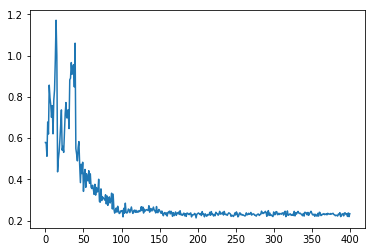

Pourcentage de succes: 100.0


0.23367913546241734

In [6]:
data_learn = [[gener[0][i], -1] for i in range(len(gener[0])//2)] + [[gener[1][i], 1] for i in range(len(gener[1])//2)]
test = [[gener[0][i], -1] for i in range(len(gener[0])//2, len(gener[0]))] +\
       [[gener[1][i], 1] for i in range(len(gener[1])//2, len(gener[1]))]
Variationer_learn(data_learn, 500, 3, 10**-10, test)

We see that the algorithm successfully learned the right hyperspace. We could technically compute the distance between the real hyperspace and the one estimated here, but this is not part of this work. The authors did such work tough.

#### Kernel estimation

The other method is a real SVM this time (the first method can be interprated as a Kernel SVM too, but it's far from obvious). Here, we want to solve the normal quadratic problem of SVM using a kernel estimated using quantum computers. This is the kernel $K(x,y) = |<\Phi(x),\Phi(y)>|^2$, where $\Phi(x)$ is the quantum state after the first part of the circuit: the feature map. So, to estimate this value, all we have to do is to do $\Phi^*(y)\Phi(x)|0_n>$ and then measure the number of zeros. It will give the value we want, up to a sampling error. The more shots the smaller the error, it's just statistics.
![kernel.PNG](images/kernel.PNG)

The computer will be called $\frac{n(n-1)}{2}$ times, to evaluate the kernel Gram matrix, then for each value $s$ we want to label, we will have to compute $K(x_i^*,s)$ the kernel function with all support vector. That's a lot of evaluations, considering that the amount of shots for each call must be as big as possible, to have the smallest possible error.

That's why I will use the simulator for the implementation, the queue for the real devices would take too much time. And to solve the quadratic problem, we use the svm method from sklearn [here](https://scikit-learn.org/stable/modules/svm.html), to simplify the code.

In [7]:
def iUphi(circ, q, x, RegX):
    """inverted Adds a Uphi(x) gate to circ at RegX. x and RegX must be of size 2"""
    Phi = [x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])]
    circ.cx(RegX[0], RegX[1])
    circ.u1(2 * Phi[2], RegX[1])
    circ.cx(RegX[0], RegX[1])
    circ.u1(2 * Phi[1], RegX[1])
    circ.u1(2 * Phi[0], RegX[0])
    for reg in RegX:
        circ.h(reg)
    circ.cx(RegX[0], RegX[1])
    circ.u1(2 * Phi[2], RegX[1])
    circ.cx(RegX[0], RegX[1])
    circ.u1(2 * Phi[1], RegX[1])
    circ.u1(2 * Phi[0], RegX[0])
    for reg in RegX:
        circ.h(reg)
    return 1


def kern(X, Y):
    """The kernel function that takes a list of X  and Y and computes K(x,y) for each pair"""
    # Hard coded number of shots
    shots = 1024
    n = len(X)
    n_y = len(Y)
    m = min(len(X[0]), len(Y[0]))
    # Quantum circuit
    q = QuantumRegister(m, 'q')
    RegX = [q[i] for i in range(m)]
    # We will put our results here
    kernel_mat = np.zeros((n, n_y))
    print("Start of the evaluation of K, wait for {} iterations".format(n*n_y))
    for i in range(n):
        for j in range(n_y):
            # To keep track of the time
            if (i*n_y+j)%50==0:
                print("Iteration {}/{}".format((i*n_y+j), n*n_y))
            # We build and run the circuit
            circ_x = QuantumCircuit(q)
            Uphi(circ_x, q, X[i], RegX)
            iUphi(circ_x, q, Y[j], RegX)
            circ_m_x = measure_direct(circ_x, q, RegX)
            counts_test = launch(shots, circ_m_x)
            # We count the probability to get 00
            if '0' * m in counts_test:
                kernel_mat[i][j] = counts_test['0' * m] / shots
    # We check if it was an evaluation of the Gram matrix
    # Because this function can't differenciate the first evaluation and the one for the test.
    if np.array_equal(X, Y):
        #print(0.5*(kernel_mat+kernel_mat.T))
        return 0.5*(kernel_mat+kernel_mat.T)
    #print("The Kernel matrix for this is:")
    #print(kernel_mat)
    return kernel_mat


def kernel_estimation(X, Y, T, Ty):
    """The test of the Kernel method"""
    h = 0.5
    clf = svm.SVC(kernel=kern)
    clf.fit(X, Y)
    print("Success (quantum kernel): ",clf.score(T, Ty))

In [8]:
# We change the data a little bit
data_learn = [gener[0][i] for i in range(len(gener[0])//2)] + [gener[1][i] for i in range(len(gener[1])//2)]
data_lab = [-1 for i in range(len(gener[0])//2)] + [1 for i in range(len(gener[1])//2)]

test = [gener[0][i] for i in range(len(gener[0])//2, len(gener[0]))] +\
       [gener[1][i] for i in range(len(gener[1])//2, len(gener[1]))]
test_lab = [-1 for i in range(len(gener[0])//2, len(gener[0]))] +\
       [1 for i in range(len(gener[1])//2, len(gener[1]))]

kernel_estimation(data_learn, data_lab, test, test_lab)

Start of the evaluation of K, wait for 400 iterations
Iteration 0/400
Iteration 50/400
Iteration 100/400
Iteration 150/400
Iteration 200/400
Iteration 250/400
Iteration 300/400
Iteration 350/400
Start of the evaluation of K, wait for 400 iterations
Iteration 0/400
Iteration 50/400
Iteration 100/400
Iteration 150/400
Iteration 200/400
Iteration 250/400
Iteration 300/400
Iteration 350/400
Success (quantum kernel):  0.9


The final test is to see two things: how good is the Quantum Feature map to separate other data, and how hard it is for a normal svm with an other feature map to saparte the data generated. For this, we will use the dataset iris of sklearn, and compare the performance of the by default feature map of the SVM, to the quantum kernel. Then, we will do the same thing with the quantumly generated data.

In [9]:
def classical_kernel_estimation(X, Y, T, Ty):
    clf = svm.SVC(gamma='auto')
    clf.fit(X, Y)
    print("Success (classical gaussian kernel): ",clf.score(T, Ty))

def test_iris(gener):
    """The classical test"""
    iris = datasets.load_iris()
    # We sample from iris (we don't want to separate the data from its label so that's why we do it like that)
    dejavu = []
    X = []
    Y = []
    T = []
    Ty = []
    n = len(iris.target)
    for i in range(10):
        ind = r.randrange(n)
        while ind in dejavu:
            ind = r.randrange(n)
        X.append(iris.data[ind, :2])
        Y.append(-1*(iris.target[ind]==0)+1*(iris.target[ind]!=0))
        dejavu.append(ind)
        ind = r.randrange(n)
        while ind in dejavu:
            ind = r.randrange(n)
        T.append(iris.data[ind, :2])
        Ty.append(-1*(iris.target[ind]==0)+1*(iris.target[ind]!=0))
        dejavu.append(ind)
    # Our training data is now sampled
    print("Classical dataset")
    classical_kernel_estimation(X, Y, T, Ty)
    kernel_estimation(X, Y, T, Ty)
    print("Hard dataset")
    data_learn = [gener[0][i] for i in range(len(gener[0]) // 2)] +\
                 [gener[1][i] for i in range(len(gener[1]) // 2)]
    data_lab = [-1 for i in range(len(gener[0])//2)] + [1 for i in range(len(gener[1])//2)]

    test = [gener[0][i] for i in range(len(gener[0])//2, len(gener[0]))] +\
           [gener[1][i] for i in range(len(gener[1])//2, len(gener[1]))]
    test_lab = [-1 for i in range(len(gener[0])//2, len(gener[0]))] +\
           [1 for i in range(len(gener[1])//2, len(gener[1]))]

    classical_kernel_estimation(data_learn, data_lab, test, test_lab)
    #kernel_estimation(data_learn, data_lab, test, test_lab)



In [10]:
test_iris(gener)

Classical dataset
Success (classical gaussian kernel):  1.0
Start of the evaluation of K, wait for 100 iterations
Iteration 0/100
Iteration 50/100
Start of the evaluation of K, wait for 100 iterations
Iteration 0/100
Iteration 50/100
Success (quantum kernel):  0.9
Hard dataset
Success (classical gaussian kernel):  0.8


We see that the classical dataset here wasn't difficult to separate for both kernels. Other runs might give differents results, but quantum kernel will never be terrible, but never better than the classical for this case. So, maybe for easy cases like that, using classical kernels can be a better idea, but there is no great bad consequencies if we use quantum kernel for normal problems.

But we see that the classical feature map can't correctly separate the data for the hard sample, so quantum feature map can be really usefull when the data is really hard to normally separate.

Here no technique of cross-validation or model selection were applied, so it may be usefull to consider such otpion as well.

In conclusion, it could be very interesting to use this kind of quantum feature map to allow machine learning to be stronger, but just like with neural network or other kind of strong machine learning models, always check if a normal linear regression won't do the trick, because using a quantum computer to separate the two types of iris here seems a bit overkill. And other types of quantum feature maps may be investigated as well, from the same family or not.

Note that a general and better implementation of this is present in Aqua, see [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/aqua/artificial_intelligence/qsvm_kernel_classification.ipynb) and [here](https://github.com/Qiskit/qiskit-tutorials/blob/master/community/aqua/artificial_intelligence/qsvm_variational.ipynb) for more details. This work was just presentation of the algorithm itself and not the perfect implementation or user case of it.